<a href="https://colab.research.google.com/github/IllgamhoDuck/googleXproject/blob/master/(QAOA)_Quantum_Approximate_Optimization_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **QAOA** Quantum Appoximate Optimization Algorithm
**With Quantum simulator**

1. Setting Environment
2. Introduction to Quantum Approximate Optimization Algorithm
3. Quantum Simulator test $U3, R_z, R_y, R_z$ 
4. Cost and Mixer gate for QAOA
5. Different version of cost gate
6. Quantum Approximate Optimization Algorithm with quantum simulator


## Setting environment
- package install
- package import
- quantum simulator code
- ibmq, cirq amplitude / probability generator code

In [0]:
!pip install --quiet protobuf==3.8.0 networkx==2.3 tensornetwork jax jaxlib cirq qiskit nxpd pylatexenc

In [0]:
# Visualize
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

# qiskit - test and visualize
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import execute, Aer
from qiskit.providers.aer import QasmSimulator

# cirq - test and visualize
import cirq
from cirq import Circuit, Simulator
from cirq.devices import GridQubit, LineQubit
from cirq.contrib.qasm_import import circuit_from_qasm

# tensornetwork
import numpy as np
import jax
import tensornetwork as tn
# np = jax.numpy

# math
import math

# test
import os
import time
import random
from tqdm import tqdm_notebook as tqdm

In [0]:
tn.set_default_backend("numpy") # <--- Super fast
# tn.set_default_backend("jax") # <--- This is painfully slow
# tn.set_default_backend("tensorflow") # <--- TF1.0 dreadfully slow TF2.0 ROCKET!!!! after 23 qubit! :D
# tn.set_default_backend("pytorch") # <--- Doesn't support complex datatype :(
qasm_simulator = Aer.get_backend('qasm_simulator')
statevector_simulator = Aer.get_backend('statevector_simulator')

class colors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    CEND      = '\33[0m'
    CBOLD     = '\33[1m'
    CITALIC   = '\33[3m'
    CURL      = '\33[4m'
    CBLINK    = '\33[5m'
    CBLINK2   = '\33[6m'
    CSELECTED = '\33[7m'

    CBLACK  = '\33[30m'
    CRED    = '\33[31m'
    CGREEN  = '\33[32m'
    CYELLOW = '\33[33m'
    CBLUE   = '\33[34m'
    CVIOLET = '\33[35m'
    CBEIGE  = '\33[36m'
    CWHITE  = '\33[37m'

    CBLACKBG  = '\33[40m'
    CREDBG    = '\33[41m'
    CGREENBG  = '\33[42m'
    CYELLOWBG = '\33[43m'
    CBLUEBG   = '\33[44m'
    CVIOLETBG = '\33[45m'
    CBEIGEBG  = '\33[46m'
    CWHITEBG  = '\33[47m'

    CGREY    = '\33[90m'
    CRED2    = '\33[91m'
    CGREEN2  = '\33[92m'
    CYELLOW2 = '\33[93m'
    CBLUE2   = '\33[94m'
    CVIOLET2 = '\33[95m'
    CBEIGE2  = '\33[96m'
    CWHITE2  = '\33[97m'

    CGREYBG    = '\33[100m'
    CREDBG2    = '\33[101m'
    CGREENBG2  = '\33[102m'
    CYELLOWBG2 = '\33[103m'
    CBLUEBG2   = '\33[104m'
    CVIOLETBG2 = '\33[105m'
    CBEIGEBG2  = '\33[106m'
    CWHITEBG2  = '\33[107m'

color = colors

In [0]:
class QuantumSimulator():
    """Quantum simulator with tensornetwork"""
    def __init__(self, qbit_n):
        """
        Args:
            qbit_n: The number of total qubit size
            circuit: Where to store gate
        """
        assert qbit_n > 0, "Qubit size should be at least 1"
        self.qbit_n = qbit_n
        self.circuit = []

    def initialize_circuit(self):
        """
        Initialize the circuit to execute

        Args:
            qbits: Store the first initialized qubits
            measures: Store the edge that used for measure for each qubit
        """
        # Initialize qubit
        self.qbits = [tn.Node(np.array([1 + 0j, 0 + 0j])) for _ in range(self.qbit_n)]

        # Storing the Edge node that will be used to measure for each qubit
        self.measures = [self.qbits[i][0] for i in range(self.qbit_n)]
        self.amplitude = None
        self.result = {}
        self.result_prob = {}
    
    def connect_qubits(self):
        """
        Make the seperate tensornetworks to one tensornetwork using
        2 qubit identity gate
        CI - Control Identity
             [[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]]
        """
        for i in range(self.qbit_n - 1):
            self.add_ci(i, i + 1)

    def x(self, qbit_i):
        """
        Add X gate to specific 1 qubit index 
        x(qbit_i=0)
        """
        self.circuit.append(('x', qbit_i))

    def y(self, qbit_i):
        """
        Add Y gate to specific 1 qubit index 
        y(qbit_i=5)
        """
        self.circuit.append(('y', qbit_i))

    def z(self, qbit_i):
        """
        Add Z gate to specific 1 qubit index 
        z(qbit_i=3)
        """
        self.circuit.append(('z', qbit_i))

    def h(self, qbit_i):
        """
        Add H gate to specific 1 qubit index 
        h(qbit_i=2)
        """
        self.circuit.append(('h', qbit_i))

    def t(self, qbit_i):
        """
        Add T gate to specific 1 qubit index 
        t(qbit_i=0)
        """
        self.circuit.append(('t', qbit_i))

    def rx(self, theta, qbit_i):
        """
        Add RX gate to specific 1 qubit index 
        RX(theta=math.pi, qbit_i=0)
        """
        self.circuit.append(('rx', theta, qbit_i))

    def ry(self, theta, qbit_i):
        """
        Add RY gate to specific 1 qubit index 
        RY(theta=math.pi, qbit_i=0)
        """
        self.circuit.append(('ry', theta, qbit_i))
    
    def rz(self, theta, qbit_i):
        """
        Add RZ gate to specific 1 qubit index 
        RZ(theta=math.pi, qbit_i=0)
        """
        self.circuit.append(('rz', theta, qbit_i))
    
    def u1(self, gamma, qbit_i):
        """
        Add U1 gate to specific 1 qubit index 
        u1(gamma=math.pi, qbit_i=0)
        """
        self.circuit.append(('u1', gamma, qbit_i))

    def u3(self, theta, phi, gamma, qbit_i):
        """
        Add U3 gate to specific 1 qubit index 
        u3(theta=0, phi=1, gamma=math.pi, qbit_i=0)
        """
        self.circuit.append(('u3', theta, phi, gamma, qbit_i))

    def swap(self, qbit_c, qbit_t):
        """
        Add SWAP gate to specific 2 qubit(control / target) index
        control and target qubit must be different 
        cx(qbit_c=0, qbit_t=1)
        """
        self.circuit.append(('swap', qbit_c, qbit_t))

    def cx(self, qbit_c, qbit_t):
        """
        Add CX gate to specific 2 qubit(control / target) index
        control and target qubit must be different 
        cx(qbit_c=0, qbit_t=1)
        """
        self.circuit.append(('cx', qbit_c, qbit_t))

    def cy(self, qbit_c, qbit_t):
        """
        Add CY gate to specific 2 qubit(control / target) index
        control and target qubit must be different 
        cy(qbit_c=3, qbit_t=2)
        """
        self.circuit.append(('cy', qbit_c, qbit_t))

    def cz(self, qbit_c, qbit_t):
        """
        Add CZ gate to specific 2 qubit(control / target) index
        control and target qubit must be different 
        cz(qbit_c=2, qbit_t=4)
        """
        self.circuit.append(('cz', qbit_c, qbit_t))

    def ch(self, qbit_c, qbit_t):
        """
        Add CH gate to specific 2 qubit(control / target) index
        control and target qubit must be different 
        ch(qbit_c=1, qbit_t=3)
        """
        self.circuit.append(('ch', qbit_c, qbit_t))
    
    def cu1(self, gamma, qbit_c, qbit_t):
        """
        Add Phase shift CU1 gate to specific 2 qubit(control / target) index
        control and target qubit must be different 
        cu1(gamma=math.pi / 4, qbit_c=1, qbit_t=3)
        """
        self.circuit.append(('cu1', gamma, qbit_c, qbit_t))
    
    def ccx(self, qbit_c1, qbit_c2, qbit_t):
        """
        Add CCX gate to specific 3 qubit(control1 / control2 / target) index
        control and target qubit must be different 
        ccx(qbit_c1=0, qbit_c2=1 qbit_t=2)
        """
        self.circuit.append(('ccx', qbit_c1, qbit_c2, qbit_t))

    def add_x(self, qbit_i):
        X = tn.Node(np.array([[0, 1],
                              [1, 0]]))
        self.measures[qbit_i] ^ X[0]
        self.measures[qbit_i] = X[1]

    def add_y(self, qbit_i):
        Y = tn.Node(np.array([[0, 1j],
                              [-1j, 0]]))
        self.measures[qbit_i] ^ Y[0]
        self.measures[qbit_i] = Y[1]

    def add_z(self, qbit_i):
        Z = tn.Node(np.array([[1, 0],
                              [0, -1]]))
        self.measures[qbit_i] ^ Z[0]
        self.measures[qbit_i] = Z[1]

    def add_h(self, qbit_i):
        h_f = 1/math.sqrt(2)
        H = tn.Node(np.array([[h_f, h_f],
                              [h_f, -h_f]]))
        self.measures[qbit_i] ^ H[0]
        self.measures[qbit_i] = H[1]

    def add_t(self, qbit_i):
        e_j_pi = math.e ** ((1j * math.pi) / 4)
        T = tn.Node(np.array([[1, 0],
                              [0, e_j_pi]]))
        self.measures[qbit_i] ^ T[0]
        self.measures[qbit_i] = T[1]

    def add_rx(self, theta, qbit_i):
        c_00 = math.cos(theta/2)
        c_01 = -1j*math.sin(theta/2)
        c_10 = -1j*math.sin(theta/2)
        c_11 = math.cos(theta/2)
        RX = tn.Node(np.array([[c_00, c_01],
                               [c_10, c_11]]))
        self.measures[qbit_i] ^ RX[0]
        self.measures[qbit_i] = RX[1]

    def add_ry(self, theta, qbit_i):
        c_00 = math.cos(theta/2)
        c_01 = math.sin(theta/2)
        c_10 = -math.sin(theta/2)
        c_11 = math.cos(theta/2)
        RY = tn.Node(np.array([[c_00, c_01],
                               [c_10, c_11]]))
        self.measures[qbit_i] ^ RY[0]
        self.measures[qbit_i] = RY[1]

    def add_rz(self, theta, qbit_i):
        """if we consider global phase e^ipi/2 its same as u1"""
        self.add_u1(theta, qbit_i)
        # c_00 = math.e**(-1j*(theta/2))
        # c_01 = 0
        # c_10 = 0
        # c_11 = math.e**(1j*(theta/2))
        # RZ = tn.Node(np.array([[c_00, c_01],
        #                        [c_10, c_11]]))
        # self.measures[qbit_i] ^ RZ[0]
        # self.measures[qbit_i] = RZ[1]

    def add_u1(self, gamma, qbit_i):
        shift = math.e ** (1j * gamma)
        U1 = tn.Node(np.array([[1, 0],
                               [0, shift]]))
        self.measures[qbit_i] ^ U1[0]
        self.measures[qbit_i] = U1[1]    
    
    def add_u3(self, theta, phi, gamma, qbit_i):
        c_00 = math.cos(theta/2)
        c_01 = math.e**(1j*phi) * math.sin(theta/2)
        c_10 = -math.e**(1j*gamma) * math.sin(theta/2)
        c_11 = math.e**(1j*gamma + 1j*phi) * math.cos(theta/2)
        U3 = tn.Node(np.array([[c_00, c_01],
                               [c_10, c_11]]))
        self.measures[qbit_i] ^ U3[0]
        self.measures[qbit_i] = U3[1]
    
    def add_swap(self, qbit_c, qbit_t):
        """
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
        """
        swap = np.array([[1, 0, 0, 0],
                         [0, 0, 1, 0],
                         [0, 1, 0, 0],
                         [0, 0, 0, 1]])
        SWAP = tn.Node(swap.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ SWAP[0]
        self.measures[qbit_t] ^ SWAP[1]
        self.measures[qbit_c] = SWAP[2]
        self.measures[qbit_t] = SWAP[3]

    def add_cx(self, qbit_c, qbit_t):
        """
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
        """
        cx = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 0, 1],
                       [0, 0, 1, 0]])
        CX = tn.Node(cx.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CX[0]
        self.measures[qbit_t] ^ CX[1]
        self.measures[qbit_c] = CX[2]
        self.measures[qbit_t] = CX[3]

    def add_cy(self, qbit_c, qbit_t):
        """
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
        """
        cy = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 0, 1j],
                       [0, 0, -1j, 0]])
        CY = tn.Node(cy.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CY[0]
        self.measures[qbit_t] ^ CY[1]
        self.measures[qbit_c] = CY[2]
        self.measures[qbit_t] = CY[3]


    def add_cz(self, qbit_c, qbit_t):
        """
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
        """
        cz = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 1, 0],
                       [0, 0, 0, -1]])
        CZ = tn.Node(cz.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CZ[0]
        self.measures[qbit_t] ^ CZ[1]
        self.measures[qbit_c] = CZ[2]
        self.measures[qbit_t] = CZ[3]

    def add_ch(self, qbit_c, qbit_t):
        """
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
            h_f: hadamard factor
        """
        h_f = 1/math.sqrt(2)
        ch = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, h_f, h_f],
                       [0, 0, h_f, -h_f]])
        CH = tn.Node(ch.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CH[0]
        self.measures[qbit_t] ^ CH[1]
        self.measures[qbit_c] = CH[2]
        self.measures[qbit_t] = CH[3]

    def add_ci(self, qbit_c, qbit_t):
        """
        Control Identity matrix for connect
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
        """
        ci = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 1, 0],
                       [0, 0, 0, 1]])
        CI = tn.Node(ci.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CI[0]
        self.measures[qbit_t] ^ CI[1]
        self.measures[qbit_c] = CI[2]
        self.measures[qbit_t] = CI[3]
    
    def add_cu1(self, gamma, qbit_c, qbit_t):
        """
        Control Phase Shift gate U1 for connect
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
            gamma: Phase shift value
        """
        shift = math.e ** (1j * gamma)
        cu1 = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 1, 0],
                       [0, 0, 0, shift]])
        CU1 = tn.Node(cu1.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CU1[0]
        self.measures[qbit_t] ^ CU1[1]
        self.measures[qbit_c] = CU1[2]
        self.measures[qbit_t] = CU1[3]

    def add_ccx(self, qbit_c1, qbit_c2, qbit_t):
        """
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
        """
        ccx = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                        [0, 1, 0, 0, 0, 0, 0, 0],
                        [0, 0, 1, 0, 0, 0, 0, 0],
                        [0, 0, 0, 1, 0, 0, 0, 0],
                        [0, 0, 0, 0, 1, 0, 0, 0],
                        [0, 0, 0, 0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 1],
                        [0, 0, 0, 0, 0, 0, 1, 0]])
        CCX = tn.Node(ccx.reshape((2, 2, 2, 2, 2, 2)))
        self.measures[qbit_c1] ^ CCX[0]
        self.measures[qbit_c2] ^ CCX[1]
        self.measures[qbit_t] ^ CCX[2]
        self.measures[qbit_c1] = CCX[3]
        self.measures[qbit_c2] = CCX[4]
        self.measures[qbit_t] = CCX[5]

    def generate_qiskit_circuit(self):
        """Visualize the gate using Qiskit"""
        qasm = self.circuit_to_qasm(self.circuit, self.qbit_n)
        statevector = self.circuit_to_qasm(self.circuit, self.qbit_n, False)
        ibmq_circuit_qasm = QuantumCircuit.from_qasm_str(qasm)
        ibmq_circuit_statevector = QuantumCircuit.from_qasm_str(statevector)
        return ibmq_circuit_qasm, ibmq_circuit_statevector

    def circuit_to_qasm(self, circuit, qubit_size, measure=True):
        # Add meta data
        qasm_text = 'OPENQASM 2.0;\ninclude "qelib1.inc";\n'

        # Add quantum bits and classical bits
        qasm_text += 'qreg q[{0}];\ncreg c[{0}];\n'.format(qubit_size)

        # Add quantum gates
        for gate in circuit:
            # 1 qubit gate
            if len(gate) == 2 or gate[0] in ['u1', 'u3', 'rx', 'ry', 'rz']:
                if gate[0] in ['u1', 'u3', 'rx', 'ry', 'rz']:
                    if gate[0] == 'u3':
                        qasm_text += '{0}({1},{2},{3}) q[{4}];\n'.format(gate[0],
                                                                         gate[1],
                                                                         gate[2],
                                                                         gate[3],
                                                                         gate[4])
                    else:
                        qasm_text += '{0}({1}) q[{2}];\n'.format(gate[0], gate[1], gate[2])
                else:
                    qasm_text += '{0} q[{1}];\n'.format(gate[0], gate[1])
            # 2 qubit gate
            elif len(gate) == 3 or gate[0] == 'cu1':
                if (gate[0] == 'cu1'):
                    qasm_text += '{0}({1}) q[{2}],q[{3}];\n'.format(gate[0], gate[1], gate[2], gate[3])
                else:
                    qasm_text += '{0} q[{1}],q[{2}];\n'.format(gate[0], gate[1], gate[2])
            elif len(gate) == 4:
                qasm_text += '{0} q[{1}],q[{2}],q[{3}];\n'.format(gate[0],
                                                                  gate[1],
                                                                  gate[2],
                                                                  gate[3])
            else:
                raise NotImplementedError("Quantum simulator doesn't support qubit gates more than 3")

        # Add measure gate
        if measure == True:
            for qbit_i in range(qubit_size):
                qasm_text += 'measure q[{0}] -> c[{0}];\n'.format(qbit_i)

        return qasm_text
        

    def generate_result(self):
        for i in range(2 ** self.qbit_n):
            # Generate statevector
            statevector = ""
            for shift in range(self.qbit_n):
                statevector = str((i >> shift) & 1) + statevector
            
            # Check the amplitude
            amp = self.amplitude[self.bitstring_to_int(statevector)]
            amp = complex(str(amp))

            if amp == 0:
                continue

            # TODO: Figure out how to get value out of jax array
            self.result[statevector] = amp 
            self.result_prob[statevector] = (amp*amp.conjugate()).real

    def bitstring_to_int(self, bitstring):
        int_list = []
        for i in bitstring[::-1]:
            int_list.append(int(i))
        return tuple(int_list)

    def execute_circuit(self):
        """
        gate is structed as following
        1 qubit gate - (gate_name, qubit_index)
        2 qubit gate - (gate_name, qubit_control_index, qubit_target_index)
        """
        gate_1 = ['x', 'y', 'z', 'h', 't', 'rx', 'ry', 'rz', 'u1', 'u3']
        gate_2 = ['swap', 'cx', 'cy', 'cz', 'ch', 'cu1']
        gate_3 = ['ccx']
        gate_1_func = [self.add_x, self.add_y, self.add_z, self.add_h, self.add_t, self.add_rx, self.add_ry, self.add_rz, self.add_u1, self.add_u3]
        gate_2_func = [self.add_swap, self.add_cx, self.add_cy, self.add_cz, self.add_ch, self.add_cu1]
        gate_3_func = [self.add_ccx]

        # Connect the qubits
        for gate in self.circuit:
            if gate[0] in gate_2:
                i = gate_2.index(gate[0])
                if gate[0] == 'cu1':
                    gate_2_func[i](gate[1], gate[2], gate[3])
                else:
                    gate_2_func[i](gate[1], gate[2])
            elif gate[0] in gate_1:
                i = gate_1.index(gate[0])
                if gate[0] in ['rx', 'ry', 'rz', 'u1']:
                    gate_1_func[i](gate[1], gate[2])
                elif gate[0] == 'u3':
                    gate_1_func[i](gate[1], gate[2], gate[3], gate[4])
                else:
                    gate_1_func[i](gate[1])
            elif gate[0] in gate_3:
                i = gate_3.index(gate[0])
                gate_3_func[i](gate[1], gate[2], gate[3])
            else:
                raise NotImplementedError("Gate {} is not supported".format(gate[0]))

        nodes = tn.reachable(self.qbits[0])
        self.amplitude = tn.contractors.greedy(nodes, output_edge_order=self.measures).tensor

    def clear_circuit(self):
        self.circuit = []

    def change_qubit_size(self, size):
        assert size > 0, "Qubit size should be at least 1"
        self.qbit_n = size

    def execute(self):
        assert self.qbit_n > 0, "Qubit size should be at least 1"
        self.initialize_circuit()
        self.connect_qubits()
        self.execute_circuit()
        self.generate_result()


In [0]:
def generate_ibmq_result(ibmq_result, qubit_size):
    """
    Generate statevector dictionary stores probability of ibmq simulator
    based on amplitude from ibmq statevector simulator
    """
    ibmq_amplitude = ibmq_result.data()['statevector']
    ibmq_amp = {}
    ibmq_prob = {}
    for i in range(2 ** qubit_size):
        # Generate statevector
        statevector = ""
        for shift in range(qubit_size):
            statevector = str((i >> shift) & 1) + statevector

        # Check the amplitude
        amp_list = ibmq_amplitude[i]
        amp = complex(amp_list[0], amp_list[1])

        if amp == 0:
            continue

        ibmq_amp[statevector] = amp
        ibmq_prob[statevector] = (amp*amp.conjugate()).real
    
    print(ibmq_amp)
    print(ibmq_prob)

def generate_cirq_result(cirq_result, qubit_size):
    """
    Generate statevector dictionary stores probability of cirq simulator
    based on amplitude from cirq statevector simulator
    """
    cirq_amplitude = cirq_result.final_state
    cirq_amp = {}
    cirq_prob = {}
    for i in range(2 ** qubit_size):
        # Generate statevector
        statevector = ""
        for shift in range(qubit_size):
            statevector = str((i >> shift) & 1) + statevector
        statevector = statevector[::-1]

        # Check the amplitude
        amp = cirq_amplitude[i]

        if amp == 0:
            continue

        cirq_amp[statevector] = amp
        cirq_prob[statevector] = (amp*amp.conjugate()).real
    
    print(cirq_amp)
    print(cirq_prob)

## Introduction to Quantum Approximate Optimization Algorithm

1. What is Quantum Approximate Optimization Algorithm?
3. Compared to Classic algorithm


In [0]:
#@title DUCKY!
%%html
<marquee style='width: 100%; color: blue;'><b>DUCKY! DUCKY! DUCKY! DUCKY! DUCKY!</b></marquee>

### 1. What is Quantum Approximate Optimization Algorithm?


 1. Combinatorial Optimization
 1. Maxcut Problem
 2. Quantum Approximate Optimization Algorithm

 
    Before going to QAOA(Quantum Approximate Optimization Algorithm)
    let's check the bottom knowledge

**Combinatorial Optimization**

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d2/Minimum_spanning_tree.svg/600px-Minimum_spanning_tree.svg.png" width=300px>

In operations research, applied mathematics and theoretical computer science, combinatorial optimization is a topic that consists of finding an optimal object from a finite set of objects. In many such problems, exhaustive search is not tractable. It operates on the domain of those optimization problems in which the set of feasible solutions is discrete or can be reduced to discrete, and in which the goal is to find the best solution. Some common problems involving combinatorial optimization are the travelling salesman problem ("TSP"), the minimum spanning tree problem ("MST"), and the knapsack problem.

Formally, a combinatorial optimization problem $A$ is a quadruple $(I, f, m, g)$, where

* $I$ is a set of instances
* given an instance $x \in I$, $f(x)$ is the finite set of feasible solutions
* given an instance $x$ and a feasible solution $y$ of $x$, $m(x, y)$ denotes the measure of $y$, which is usually a positive real
* $g$ is the goal function, and is either $\min$ or $\max$

$_\text{“Combinatorial Optimization.” Wikipedia, Wikimedia Foundation, 20 Jan. 2020, en.wikipedia.org/wiki/Combinatorial_optimization.}$

    Maxcut is combinatorial optimization

**Maxcut Problem**


<img src="https://miro.medium.com/max/2076/1*k-Ul0kYhGTSGF4cVGIedTg.png" width=300px>

$_\text{JavaFXpert. “The Variational Quantum Eigensolver.”}$
$_\text{Medium, Qiskit, 12 Sept. 2019, medium.com/qiskit/the-variational-quantum-eigensolver-43f7718c2747}$

For a graph, a maximum cut is a cut whose size is at least the size of any other cut. The problem of finding a maximum cut in a graph is known as the Max-Cut Problem.

The problem can be stated simply as follows. One wants a subset S of the vertex set such that the number of edges between S and the complementary subset is as large as possible.

There is a more general version of the problem called weighted Max-Cut. In this version each edge has a real number, its weight, and the objective is to maximize not the number of edges but the total weight of the edges between S and its complement. The weighted Max-Cut problem is often, but not always, restricted to non-negative weights, because negative weights can change the nature of the problem.

$_\text{“Maximum Cut.” Wikipedia, Wikimedia Foundation, 1 Dec. 2019, en.wikipedia.org/wiki/Maximum_cut}$









**Quantum Approximate Optimization Algorithm (QAOA)**

For **combinatorial optimization**, the Quantum Approximate Optimization Algorithm (QAOA) briefly had a better approximation ratio than any known polynomial time classical algorithm (for a certain problem), until a more effective classical algorithm was proposed. The relative speed-up of the quantum algorithm is an open research question.

The heart of the QAOA relies on the use of unitary operators dependent on  angles, where is an input integer. These operators are iteratively applied on a state that is an equal-weighted quantum superposition of all the possible states in the computational basis. In each iteration, the state is measured in the computational basis and is calculated. After a sufficient number of repetitions, the value of is almost optimal, and the state being measured is close to being optimal as well.

$_\text{Quantum Optimization Algorithms.” Wikipedia, Wikimedia Foundation, 5 Sept. 2019, en.wikipedia.org/wiki/Quantum_optimization_algorithms}$


    The following circuit show the qaoa in maxcut


<img src="https://d3i71xaburhd42.cloudfront.net/1dae572c4606b5d8ea9e1f88c9c16d287851d7a5/2-Figure1-1.png" width=400px>

$_\text{Leo Zhou, Sheng-Tao Wang, et al. “[PDF] Quantum Approximate Optimization Algorithm: Performance, Mechanism, and Implementation on Near-Term Devices.: Semantic Scholar.”}$
$_\text{www.semanticscholar.org/paper/Quantum-Approximate-Optimization-Algorithm:-and-on-Zhou-Wang/1dae572c4606b5d8ea9e1f88c9c16d287851d7a5}$

n this generic formulation, there are n binary decisions variables, z, and m binary functions of those variables, C(z), called clauses. The challenge is to find the assignment of z that maximizes the number of clauses that can be satisfied. This is the so-called MaxSat problem, which is NP-Hard in general, and is an optimization variant of the well-known satisfiability problem, which is the NP-Complete.

maximize: $\sum\limits_{\alpha=1}^{m}C_\alpha(z)$

$\scriptsize z_i \in \{0, 1\} \; \forall i \in \{1, ..., n\}$

    In general, the MaxCut problem is characterized by 
    the following unconstrained discrete maximization problem

maximize: $\sum\limits_{i,j \in \mathcal{E}}\frac{1}{2}(1 - \sigma_i\sigma_j)$

$\scriptsize \sigma_i \in \{-1, 1\} \; \forall i \in \mathcal{N} \qquad\qquad\qquad\qquad\qquad\qquad\qquad (1)$

In this formulation, there is one binary decision variable for each node in the graph, indicating which set it belongs. The objective function consists of one term for each edge in the graph. This term is 0 if the the nodes of that edge take the same value and 1 otherwise. Consequently, the optimal solution of (1) will be a maximal cut of the graph G. Interestingly, the form of (1) also highlights that finding a maximal cut of G is equivalent of find a ground state of the antiferromagnet of G in an Ising model interpretation.



**Algorithm**

MaxCut quantum Hamiltonian

$\prod\limits_{j=1}^{n}H_j\prod\limits_{k=1}^{r}\left(\prod\limits_{j=1}^{n}e^{-i\beta_kX_j}\prod\limits_{\alpha=1}^{m}e^{-i\gamma_kC_\alpha}\right)$

To apply this algorithm the user first translates the clause functions $C_\alpha(z)$ into equivalent quantum Hamiltonians $C_\alpha$ and then select a number of rounds $r\geq1$ and two angles $0\leq\beta\leq\pi$ and $0\leq\gamma\leq2\pi$ for each round. Startingfromqubits in the $|0 ... 0\rangle$ state, the following quantum operation is applied

$C_{i,j} = \frac{1}{2}(I - Z_i \otimes Z_j)$

$\prod\limits_{j\in\mathcal{N}}H_j\prod\limits_{k=1}^{r}\left(\prod\limits_{j\in\mathcal{N}}e^{-i\beta_kX_j}\prod\limits_{a, b \in \mathcal{E}}e^{-i\frac{\gamma_k}{2}(I - Z_a \otimes Z_b)}\right)$

$_\text{Coles, et al. “Quantum Algorithm Implementations for Beginners.” ArXiv.org, 10 Apr. 2018, arxiv.org/abs/1804.03719}$

$\;$

$\mathsf{7\;steps\;to\;build\;QAOA}$

    1. Begin with trial state

$|s\rangle = |H\rangle^{\otimes n}|0\rangle^{\otimes n}$

    2. Initialize parameter β and γ
    
**(Classical computer)**

Initialize 2$p$ parameters $\beta$ and $\gamma$ (determine what angles to use for gates) This could be all 0 if no better choice is implied.

    3. Construct Quantum Circuit

**(Quantum computer)**

Construct $|\gamma, \beta \rangle$ using

$U(B, \beta_p)U(C, \gamma_p)· · ·U(B, \beta_2)U(C, \gamma_2)U(B, \beta_1)U(C, \gamma_1)|s\rangle$ 

with angles determined in previous step. The circuit for 
individual operator is shown in previous sections. Now

$|\psi\rangle_{new} = |\gamma, \beta\rangle$ is updated.

    4. Measure

**(Quantum computer)**

Measure $|\gamma, \beta_i\rangle$ in computational basis set and obtain a value $|z\rangle$

    5. Calculate Energy

**(Classical computer)**

Using $\sum_{m}^{k=1} C_k(z)$ to calculate $C(z)$.

    6. Repeat 1 - 4 (for real device)

**Aware that this is for Real device. Because real device has noise so we have to get the repeat several times and get the best one**

**Repeat step 1 to 4 to a number of times**. It means we measure the same $|\gamma, \beta_i\rangle$ for many times, and to obtain distribution of states $|z\rangle$. Each $|z\rangle$ corresponds a $C(z)$ which results in a distribution of $C(z)$ with largest value $C(z'')$ and average (expectation) value of $C$ will be $\langle \gamma, \beta|C|\gamma, \beta\rangle$. We only output the $C(z'')$ and it’s eigenvector $|z''\rangle$ as the result of applying $2p$ parameters $\beta$ and $\gamma$.

    7. search

<img src="https://d3i71xaburhd42.cloudfront.net/5608d1380209942f508d810aec444175f95bf1af/3-Figure1-1.png" width=500px>

$_\text{Ho, Wen Wei, and Timothy H. Hsieh. “Figure 1 from Efficient Preparation of Non-Trivial Quantum States Using the Quantum Approximate Optimization Algorithm: Semantic Scholar.”}$
$_\text{Figure 1 from Efficient Preparation of Non-Trivial Quantum States Using the Quantum Approximate Optimization Algorithm | Semantic Scholar, 1 Jan. 1970,}$
$_\text{www.semanticscholar.org/paper/Efficient-preparation-of-non-trivial-quantum-states-Ho-Hsieh/5608d1380209942f508d810aec444175f95bf1af/figure/0}$

**Select a new set of $2p$ parameters $\gamma$ and $\gamma$, repeat step 3 to 6**. Obtain a distribution of $C(z'')$ and choose the largest one as the final output. The termination condition depends on how you update next set of angles.

Consider this as a $2p$ parameter function optimization problem with only function evaluation (step 3 to 6)
involves quantum system. If you choose angles from a fine grid, then just run through $2p$ dimensional grid.
This could become prohibitively large as the number grows $O(r2p)$ where $r$ is roughly the grid resolution
(number of points) for each parameter. **Other ways of updating new angles including gradient descend** or other
classical optimization methods. If so, the algorithm will terminate with a preset convergence value.

    At this colab we are going to use gradient descent :)

$_\text{Wang, Qingfeng, and Tauqir Abdullah. “An Introduction to Quantum Optimization Approximation Algorithm: Semantic Scholar.”}$

$_\text{1 Jan. 1970, www.semanticscholar.org/paper/An-Introduction-to-Quantum-Optimization-Algorithm-Wang-Abdullah/32f82d9d4e496d80e4cdc994073c8ddd4e680256}$


### 2. Compared to Classic algorithm

    1. QAOA for Max 3-XORSAT
    2. QAOA for Maximum Cut



**QAOA for Max 3-XORSAT**

Author | Year | $\qquad$ Result $\qquad$ | Type
------- | ------- |------- | -------
Trevisan | 2000 | <center>$\left(\frac{1}{2}\right)$ + $\left(\frac{O(1)}{d}\right)$$m$ | Classical
Farhi et al. | 2014 | <center>$\left(\frac{1}{2}\right)$ + $\left(\frac{O(1)}{d^{3/4}}\right)$$m$ | Quantum
Barak et al. | 2015 | <center>$\left(\frac{1}{2}\right)$ + $\left(\frac{O(1)}{\sqrt{d}}\right)$$m$ | Classical
Farhi et al. | 2015 | <center>$\left(\frac{1}{2}\right)$ + $\left(\frac{O(1)}{logd\sqrt{d}}\right)$$m$ | Quantum

$_\text{Farhi et al., A Quantum Approximate Optimization Algorithm..., arXiv:1412.6062v2, 2015}$

**QAOA for Maximum Cut**

Author | Year | $\qquad$ Result $\qquad$ | Type
------- | ------- |------- | -------
Shearer | 1992 | <center>$\left(\frac{1}{2}\right)$ + $\left(\frac{0.177}{\sqrt{d}}\right)$ | Classical
Hirvonen et al. | 2014 | <center>$\left( \frac{1}{2}\right)$ + $\left(\frac{0.281}{\sqrt{d}}\right)$ | Classical
Parekh et al. | 2017 | <center>$\left( \frac{1}{2}\right)$ + $\left(\frac{0.303}{\sqrt{d}}\right)$ | Quantum

$_\text{Parekh, and Ojas D. “Quantum Optimization Algorithms.” Quantum Optimization Algorithms. (Conference) | OSTI.GOV, 1 June 2018, www.osti.gov/servlets/purl/1526360.}$

**QAOA is unstable than classic but achieved quantum supremacy**

## Cost & Mixer gate for QAOA

    Introduction to built the Unitary gate
    Cost(Edge) and Mixer(Vertice) 
    Consider the following formula while going through

$e^{ixA} = cos(x)I + isin(x)A$

$cos(\theta) = cos(-\theta)$

$sin(\theta) = -sin(-\theta)$

$e^{i\theta} = cos(\theta) + isin(\theta)$

### **Cost Hamiltonian $U(H_C, \gamma)$**

$e^{-i \gamma \frac{I - Z_i Z_j}{2}}$

$= e^{-i \gamma \frac{I - Z_i \otimes Z_j}{2}}$

$= e^{-i \gamma \frac{I - Z_i \otimes Z_j}{2}}$

$= e^{-i\gamma
\begin{pmatrix}
0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 \\
\end{pmatrix}}$

$=
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & e^{-i\gamma} & 0 & 0 \\
0 & 0 & e^{-i\gamma} & 0 \\
0 & 0 & 0 & 1 \\
\end{pmatrix}$

$\therefore C_{u1}(2\gamma)(0, 1)U1(-\gamma)(0)U1(-\gamma)(1)$

    We can make the sign opposite(+->-) and use it too

$C_{u1}(-2\gamma)(0, 1)U1(\gamma)(0)U1(\gamma)(1)$

$\small\text{How to make the matrix with basis gates?}$



#### example 1 - U1 / CU1

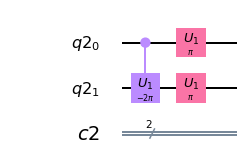

In [0]:
#@title 
gamma = math.pi
q = QuantumRegister(2)
c = ClassicalRegister(2)
ibmq_circuit = QuantumCircuit(q, c)
ibmq_circuit.cu1(-2*gamma, 0, 1)
ibmq_circuit.u1(gamma, 0)
ibmq_circuit.u1(gamma, 1)
ibmq_circuit.draw(output='mpl')

$C_{u1}(-2\gamma)(0, 1)(U1(\gamma) \otimes I)(I \otimes U1(\gamma))$

$=
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & e^{-2i\gamma} \\
\end{pmatrix}$
$\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & e^{i\gamma} & 0 \\
0 & 0 & 0 & e^{i\gamma} \\
\end{pmatrix}$
$\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & e^{i\gamma} & 0 & 0 \\
0 & 0 & e^{i\gamma} & 0 \\
0 & 0 & 0 & 1 \\
\end{pmatrix}$

    final form

$\therefore
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & e^{i\gamma} & 0 & 0 \\
0 & 0 & e^{i\gamma} & 0 \\
0 & 0 & 0 & 1 \\
\end{pmatrix}$

#### example 2 - X / U1 / CNOT

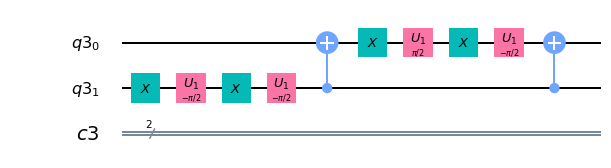

In [0]:
#@title 
gamma = math.pi
q = QuantumRegister(2)
c = ClassicalRegister(2)
ibmq_circuit = QuantumCircuit(q, c)
ibmq_circuit.x(1)
ibmq_circuit.u1(-gamma/2, 1)
ibmq_circuit.x(1)
ibmq_circuit.u1(-gamma/2, 1)
ibmq_circuit.cnot(1, 0)
ibmq_circuit.x(0)
ibmq_circuit.u1(gamma/2, 0)
ibmq_circuit.x(0)
ibmq_circuit.u1(-gamma/2, 0)
ibmq_circuit.cnot(1, 0)
ibmq_circuit.draw(output='mpl')

$(I \otimes X)(I \otimes U1(-\gamma/2))(I \otimes X)(I \otimes U1(-\gamma/2))CNOT(1, 0)(X \otimes I)(U1(\gamma/2) \otimes I)(X \otimes I)(U1(-\gamma/2) \otimes I)CNOT(1, 0)$

    Aware that 3rd U1 gate phase is not minus!

$C_{1-} = (I \otimes X)(I \otimes U1(-\gamma/2))$
$=
\begin{pmatrix}
0 & e^{-i\frac{\gamma}{2}} & 0 & 0 \\
1 & 0 & 0 & 0 \\
0 & 0 & 0 & e^{-i\frac{\gamma}{2}} \\
0 & 0 & 1 & 0 \\
\end{pmatrix}$

$C_{2-} = (X \otimes I)(U1(-\gamma/2) \otimes I)$
$=
\begin{pmatrix}
0 & 0 & e^{-i\frac{\gamma}{2}} & 0 \\
0 & 0 & 0 & e^{-i\frac{\gamma}{2}} \\
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
\end{pmatrix}$

$CNOT(1,0) = (X \otimes I)(U1(-\gamma/2) \otimes I)$
$=
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
\end{pmatrix}$

$\rightarrow C_{1-}C_{1-}CNOT(1,0)C_{2+}C_{2-}CNOT(1,0)$

$C_{1-}C_{1-}$
$=
\begin{pmatrix}
e^{-i\frac{\gamma}{2}} & 0 & 0 & 0 \\
0 & e^{-i\frac{\gamma}{2}} & 0 & 0 \\
0 & 0 & e^{-i\frac{\gamma}{2}} & 0 \\
0 & 0 & 0 & e^{-i\frac{\gamma}{2}} \\
\end{pmatrix}$

$C_{2+}C_{2-}$
$=
\begin{pmatrix}
e^{i\frac{\gamma}{2}} & 0 & 0 & 0 \\
0 & e^{i\frac{\gamma}{2}} & 0 & 0 \\
0 & 0 & e^{-i\frac{\gamma}{2}} & 0 \\
0 & 0 & 0 & e^{-i\frac{\gamma}{2}} \\
\end{pmatrix}$

    The final form

$\therefore$
$\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & e^{-i\gamma} & 0 & 0 \\
0 & 0 & e^{-i\gamma} & 0 \\
0 & 0 & 0 & 1 \\
\end{pmatrix}$


### **Mixer Hamiltonian $U(H_B, \beta)$**

$e^{-i \beta X_i}$

$= e^{-i \beta \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}}$
$= cos(-\beta)I + isin(-\beta)\begin{pmatrix}0&1\\1&0\end{pmatrix}$

$= \begin{pmatrix} cos(\beta) & -isin(\beta) \\
-isin(\beta) & cos(\beta) \end{pmatrix}$

$= U3(2\beta, \frac{-\pi}{2}, \frac{\pi}{2})$

$\therefore R_x(2\beta)$

## Different version of cost gate
change
$\gamma$ to $\pi\gamma$ for convienient calculation

    ZZ Ising gate

$e^{-i \pi \gamma Z \otimes Z } = \begin{bmatrix} e^{i \pi \gamma} & 0 & 0 & 0 \\ 0 & e^{-i \pi \gamma} & 0 & 0 \\ 0 & 0 & e^{-i \pi \gamma} & 0 \\ 0 & 0 & 0 & e^{i \pi \gamma} \\ \end{bmatrix}$

$C(Z^{r}) = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & e^{i \pi \gamma} \\ \end{bmatrix}$

$(I \otimes X) \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & e^{i \pi \gamma} \\ \end{bmatrix}(I \otimes X) = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & e^{i \pi \gamma} & 0 \\ 0 & 0 & 0 & 1 \\ \end{bmatrix}$

$(X \otimes I) \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & e^{i \pi \gamma} \\ \end{bmatrix}(X \otimes I) = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & e^{i \pi \gamma} & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ \end{bmatrix}$

$(X \otimes X) \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & e^{i \pi \gamma} \\ \end{bmatrix}(X \otimes X) = \begin{bmatrix} e^{i \pi \gamma} & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ \end{bmatrix}$

In [0]:
circuit = cirq.Circuit()
q = cirq.LineQubit.range(2)
q1 = q[0]
q2 = q[1]
gamma = 0.25
beta = -0.5

circuit.append(cirq.H(q[0]))
circuit.append(cirq.H(q[1]))

# Cost
circuit.append(cirq.CZ(q1, q2)**gamma)
circuit.append([cirq.X(q2), cirq.CZ(q1, q2)**(-1*gamma), cirq.X(q2)])
circuit.append([cirq.X(q1), cirq.CZ(q1, q2)**(-1*gamma), cirq.X(q1)])
circuit.append([cirq.X(q1), cirq.X(q2), cirq.CZ(q1, q2)**gamma, cirq.X(q1), cirq.X(q2)])

# Mixer
circuit.append(cirq.X(q[0])**beta)
circuit.append(cirq.X(q[1])**beta)

In [0]:
print(circuit)

0: ───H───@────────────@─────────X───@─────────X───X───@────────X───X^-0.5───
          │            │             │                 │
1: ───H───@^0.25───X───@^-0.25───X───@^-0.25───X───────@^0.25───X───X^-0.5───


In [0]:
generate_cirq_result(cirq.Simulator().simulate(circuit), 2)

{'00': (0.35355335-0.35355335j), '10': (0.35355335+0.35355335j), '01': (0.35355335+0.35355335j), '11': (0.35355335-0.35355335j)}
{'00': 0.24999996, '10': 0.24999996, '01': 0.24999996, '11': 0.24999996}


## Quantum Simulator test
**$U3, R_z, R_y, R_z$ Test**

    Added gate

$U3(\theta, \phi,\gamma) = \begin{pmatrix} cos(\theta/2) & -e^{i\gamma}sin(\theta/2) \\ e^{i\phi}sin(\theta/2) & e^{i\gamma + i\phi}cos(\theta/2) \end{pmatrix}$

$R_x(\theta) = \begin{pmatrix}
cos(\theta/2) & -isin(\theta/2) \\
-isin(\theta/2) & cos(\theta/2) \end{pmatrix}$

$R_y(\theta) = \begin{pmatrix} 
cos(\theta/2) & -sin(\theta/2) \\
sin(\theta/2) & cos(\theta/2) \end{pmatrix}$ 

$R_z(\theta) = \begin{pmatrix}
e^{-i\frac{\theta}{2}} & 0 \\
0 & e^{i\frac{\theta}{2}} \end{pmatrix}$


#### Quantum simulator Gate Test code



In [0]:
class QuantumSimulatorTest():
    """Test the quantum simulator"""
    def __init__(self,
                 min_qubit_size=1,
                 max_qubit_size=5,
                 min_gate_size=1,
                 max_gate_size=40):
        """
        Choose the testing enviroment
        Args:
            min_qubit_size: minimum number of the qubit size
            min_qubit_size: maximum number of the qubit size
            min_qubit_size: minimum number of the gate size
            min_qubit_size: maximum number of the gate size
        """
        self.max_qubit_size = max_qubit_size
        self.min_qubit_size = min_qubit_size
        self.max_gate_size = max_gate_size
        self.min_gate_size = min_gate_size

    def __call__(self,
                 quantum_simulator,
                 ibmq_backend,
                 test_size=10,
                 error_path=None,
                 error_file=None):
        """
        Process test
        Quantum simulator testing using ibmq qiskit
        Args:
            quantum_simulator: quantum simulator that will be used to simulate
            ibmq_backend: ibmq simulator that will be used as reference
                - qasm_simulator: show the number of shots for each statevector
                - statevector_simualtor: show the amplitude and prob for each statevector
                                         measure gates are disabled
            test_size: total test case size
            error_path: where to store the error case
            error_file: name of the error file
        """
        # Check IBMQ backend
        self.ibmq_backend = ibmq_backend.configuration().backend_name

        # Check the correct
        total = 0
        correct = 0
        test_start_time = time.time()

        # Store the error case
        if error_path:
            if not(os.path.isdir(error_path)):
                os.makedirs(error_path)
            f = open(os.path.join(error_path, error_file), 'w')

        # Run the test!
        for test_i in tqdm(range(test_size)):
            # Generate the random circuit and qasm(IBM Qiskit)
            random_qubit_size = random.randint(self.min_qubit_size, self.max_qubit_size)
            random_gate_size = random.randint(self.min_gate_size, self.max_gate_size)
            circuit, qasm = self.random_circuit(random_qubit_size, random_gate_size)

            # Print out the current test case information
            print(color.BOLD)
            print('TEST CASE [{} / {}] qubit: {} gate: {}'.format(test_i + 1,
                                                                  test_size,
                                                                  random_qubit_size,
                                                                  random_gate_size))
            print(color.ENDC)

            # Run the Quantum simulator and get the result
            qs_start_time = time.time()
            quantum_simulator.change_qubit_size(random_qubit_size)
            quantum_simulator.circuit = circuit
            quantum_simulator.execute()
            qs_end_time = time.time()

            self.qs_result = quantum_simulator.result_prob

            # Run IBM qiskit simulator and get the result
            shots = 1000 # default

            ibmq_start_time = time.time()
            ibmq_circuit = QuantumCircuit.from_qasm_str(qasm)
            self.ibmq_result = execute(ibmq_circuit, ibmq_backend, shots=shots).result()
            ibmq_end_time = time.time()

            ############################################################
            ### PRINT OUT THE INFORMATIONS #############################
            ############################################################

            # 1. Circuit information
            print(circuit)
            print(ibmq_circuit)

            # 2. Quantum simulation
            print(color.BOLD + '[ QUANTUM SIMULATOR ]' + color.ENDC)
            print(color.CURL, end="")
            print("Quantum simulator tested time: %s sec\n" % format(qs_end_time - qs_start_time))
            print(color.ENDC, end="")
            print(quantum_simulator.result)
            print(self.qs_result)
            print('')

            # 3. IBMQ simulation
            print(color.BOLD + '[ IBM QISKIT ]' + color.ENDC)
            print(color.CURL, end="")
            print("IBMQ tested time: %s sec\n" % format(ibmq_end_time - ibmq_start_time))
            print(color.ENDC, end="")
            if self.ibmq_backend == 'qasm_simulator':
                print(self.ibmq_result.get_counts())
            if self.ibmq_backend == 'statevector_simulator':
                self.generate_ibmq_result(random_qubit_size)
                print(self.ibmq_amp)
                print(self.ibmq_prob)
            print('')

            # 4. Compare the result
            print(color.BOLD + '[ COMPARE ]' + color.ENDC)
            cmp_start_time = time.time()
            error_n, cmp_total, total_error = self.compare_probability(shots)
            print(color.CURL, end="")
            print("Comparing time: %s sec" % format(time.time() - cmp_start_time))
            print(color.ENDC)
            if error_n == 0:
                print(color.OKBLUE + 'ERROR OCCUR / TOTAL CHECK: ' + color.ENDC, error_n, '/', cmp_total)
                print(color.OKBLUE + 'TOTAL ERROR: ' + color.ENDC, total_error,'\n')
            else:
                print(color.FAIL + 'ERROR OCCUR / TOTAL CHECK: ' + color.ENDC, error_n, '/', cmp_total)
                print(color.FAIL + 'TOTAL ERROR: ' + color.ENDC, total_error,'\n')

            ############################################################
            ############################################################
            ############################################################

            # Update the error information and save the error case to file
            if error_n == 0:
                correct += 1
            elif error_path and self.ibmq_backend == 'qasm_simulator':
                error_case = ""
                error_case += str(circuit) + '\n'
                error_case += '< Quantum simulator probability >\n'
                error_case += str(self.qs_result) +'\n'
                error_case += '< IBMQ statevector count information >\n'
                error_case += str(self.ibmq_result.get_counts()) + '\n'
                error_case += 'Error occur / Total check: '
                error_case += str(error_n) + '/' + str(cmp_total) + '\n'
                error_case += 'Total error: '
                error_case += str(total_error) + '\n\n'
                f.write(error_case)
            elif error_path and self.ibmq_backend == 'statevector_simulator':
                error_case = ""
                error_case += str(circuit) + '\n'
                error_case += '< Quantum simulator amplitude & probability >\n'
                error_case += str(quantum_simulator.result) +'\n'
                error_case += str(self.qs_result) +'\n'
                error_case += '< IBMQ amplitude & probability >\n'
                error_case += str(self.ibmq_amp) + '\n'
                error_case += str(self.ibmq_prob) + '\n'
                error_case += 'Error occur / Total check: '
                error_case += str(error_n) + '/' + str(cmp_total) + '\n'
                error_case += 'Total error: '
                error_case += str(total_error) + '\n\n'
                f.write(error_case)
            total += 1

        # Close the error case file
        if error_path:
            f.close()

        # Print out the final result
        if correct == total:
            print(color.OKBLUE + "The final result is {} / {}".format(correct, total) + color.ENDC)
        else:
            print(color.FAIL + "The final result is {} / {}".format(correct, total) + color.ENDC)
        print("Total tested time: %s sec" % format(time.time() - test_start_time))

    def generate_ibmq_result(self, qubit_size):
        """
        Generate statevector dictionary stores probability of ibmq simulator
        based on amplitude from ibmq statevector simulator
        """
        ibmq_amplitude = self.ibmq_result.data()['statevector']
        self.ibmq_amp = {}
        self.ibmq_prob = {}
        for i in range(2 ** qubit_size):
            # Generate statevector
            statevector = ""
            for shift in range(qubit_size):
                statevector = str((i >> shift) & 1) + statevector

            # Check the amplitude
            amp_list = ibmq_amplitude[i]
            amp = complex(amp_list[0], amp_list[1])

            if amp == 0:
                continue

            self.ibmq_amp[statevector] = amp
            self.ibmq_prob[statevector] = (amp*amp.conjugate()).real

    def compare_probability(self, shots, delta=1e-6):
        """
        Check each statevector probability and if the value is
        more than give delta(default: 1e-6) value consider as error
        """
        total_error = 0
        error_n = 0
        cmp_total = 0

        # Get statevector info from both simulator
        if self.ibmq_backend == 'qasm_simulator':
            ibmq_count = self.ibmq_result.get_counts()
            state_vectors = list(set(self.qs_result.keys()).union(set(ibmq_count.keys())))
        if self.ibmq_backend == 'statevector_simulator':
            state_vectors = list(set(self.qs_result.keys()).union(set(self.ibmq_amp.keys())))

        # Check is there is an error
        for state_vector in state_vectors:
            qs_val = self.qs_result.get(state_vector, 0)

            if self.ibmq_backend == 'qasm_simulator':
                ibmq_val = ibmq_count.get(state_vector, 0)/shots
            if self.ibmq_backend == 'statevector_simulator':
                ibmq_val = self.ibmq_prob.get(state_vector, 0)

            error = abs(qs_val - ibmq_val)
            total_error += error
            if error > delta:
                error_n += 1
            cmp_total += 1

        return error_n, cmp_total, total_error

    def random_circuit(self, qubit_size=5, gate_size=20):
        """
        Args:
            gate_1: list of 1 qubit gates
            gate_2: list of 2 qubit gates
            qubit_list: list of qubit index
        """
        # Quantum Simulator
        gate_1 = ['x', 'y', 'z', 't', 'u1', 'u3', 'rx', 'ry', 'rz']
        gate_2 = ['swap', 'cu1', 'cx', 'cy', 'cz', 'ch']
        qubit_list = list(range(qubit_size))

        circuit = []
        for _ in range(gate_size):
            if qubit_size == 1 or random.random() > 0.5:
                gate = random.choice(gate_1)
                if gate in ['rx', 'ry', 'rz', 'u1']:
                    random_gamma = random.sample([-1, 1], 1)[0] * random.randint(1, 3) * random.random()
                    circuit.append(tuple([gate, random_gamma, *random.sample(qubit_list, 1)]))
                elif gate == 'u3':
                    theta = random.sample([-1, 1], 1)[0] * random.randint(1, 3) * random.random()
                    beta = random.sample([-1, 1], 1)[0] * random.randint(1, 3) * random.random()
                    gamma = random.sample([-1, 1], 1)[0] * random.randint(1, 3) * random.random()
                    circuit.append(tuple([gate, theta, beta, gamma, *random.sample(qubit_list, 1)]))
                else:
                    circuit.append(tuple([gate, *random.sample(qubit_list, 1)]))
            else:
                gate = random.choice(gate_2)
                if gate == 'cu1':
                    random_gamma = random.sample([-1, 1], 1)[0] * random.randint(1, 3) * random.random()
                    circuit.append(tuple([gate, random_gamma, *random.sample(qubit_list, 2)]))
                else:
                    circuit.append(tuple([gate, *random.sample(qubit_list, 2)]))

        # IBM Qiskit
        qasm = self.circuit_to_qasm(circuit, qubit_size)

        return circuit, qasm
        # IBM Qiskit
        qasm = self.circuit_to_qasm(circuit, qubit_size)

        return circuit, qasm

    def circuit_to_qasm(self, circuit, qubit_size):
        # Add meta data
        qasm_text = 'OPENQASM 2.0;\ninclude "qelib1.inc";\n'

        # Add quantum bits and classical bits
        qasm_text += 'qreg q[{0}];\ncreg c[{0}];\n'.format(qubit_size)

        # Add quantum gates
        for gate in circuit:
            # 1 qubit gate
            if len(gate) == 2 or gate[0] in ['u1', 'u3', 'rx', 'ry', 'rz']:
                if gate[0] in ['u1', 'u3', 'rx', 'ry', 'rz']:
                    if gate[0] == 'u3':
                        qasm_text += '{0}({1},{2},{3}) q[{4}];\n'.format(gate[0],
                                                                         gate[1],
                                                                         gate[2],
                                                                         gate[3],
                                                                         gate[4])
                    else:
                        qasm_text += '{0}({1}) q[{2}];\n'.format(gate[0], gate[1], gate[2])
                else:
                    qasm_text += '{0} q[{1}];\n'.format(gate[0], gate[1])
            # 2 qubit gate
            elif len(gate) == 3 or gate[0] == 'cu1':
                if (gate[0] == 'cu1'):
                    qasm_text += '{0}({1}) q[{2}],q[{3}];\n'.format(gate[0], gate[1], gate[2], gate[3])
                else:
                    qasm_text += '{0} q[{1}],q[{2}];\n'.format(gate[0], gate[1], gate[2])
            elif len(gate) == 4:
                qasm_text += '{0} q[{1}],q[{2}],q[{3}];\n'.format(gate[0],
                                                                  gate[1],
                                                                  gate[2],
                                                                  gate[3])
            else:
                raise NotImplementedError("Quantum simulator doesn't support qubit gates more than 3")

        # Add measure gate
        if self.ibmq_backend == 'qasm_simulator':
            for qbit_i in range(qubit_size):
                qasm_text += 'measure q[{0}] -> c[{0}];\n'.format(qbit_i)

        return qasm_text


#### **$U3, R_z, R_y, R_z$ Test**

In [0]:
t = QuantumSimulatorTest(min_qubit_size=5,
                         max_qubit_size=5,
                         min_gate_size=10,
                         max_gate_size=50)
circuit = QuantumSimulator(1)

In [0]:
t(quantum_simulator=circuit,
  ibmq_backend=statevector_simulator,
  test_size=50)


TEST CASE [1 / 50] qubit: 5 gate: 23

[('rz', -0.6325875465061032, 2), ('u3', -0.4614696737515277, -0.7671304601753849, 0.8668228615858911, 1), ('cu1', -0.3666069321157527, 4, 1), ('cz', 1, 2), ('rz', -0.13046576692283662, 1), ('rx', 0.005244013355931942, 3), ('x', 3), ('cu1', 0.12821937291543062, 3, 0), ('u3', 1.1691399503604452, 1.8731814098164616, -0.009949838574634828, 3), ('u3', -0.2689267714114978, -0.6784070876415433, 0.23718225948225458, 1), ('ry', -0.19662733730576099, 4), ('rx', 2.66920000854339, 2), ('u3', 1.8282873613173922, -2.3037466955393673, 0.052478086327290785, 1), ('cu1', -0.4326145589373891, 3, 2), ('t', 3), ('u1', 1.7917063958914843, 0), ('ch', 4, 0), ('rx', -1.0194415701916586, 1), ('rx', 0.23670902572908403, 2), ('x', 4), ('cy', 3, 2), ('ch', 0, 2), ('cz', 3, 1)]
                                                                          »
q_0: |0>──────────────────────────────────────────────────■───────────────»
        ┌───────────────────────────────┐         

#### Small test function
**Used for testing each gate**

[ Quantum Simulator ]
{'0': (0.8253356149096783+0j), '1': (0.3050776303664274+0.4751302581520869j)}
{'0': 0.6811788772383368, '1': 0.31882112276166324}

[ Qiskit ]
{'0': (0.8253356149096783+0j), '1': (0.3050776303664274+0.4751302581520869j)}
{'0': 0.6811788772383368, '1': 0.31882112276166324}
None
{'0': 723, '1': 301}



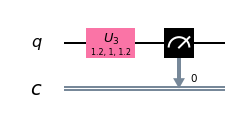

In [0]:
qubit_size = 1

# Quantum Simulator
circuit = QuantumSimulator(qubit_size)

# Add special input
circuit.u3(1.2, 1, 1.2, 0)
circuit.execute()

print(color.BOLD + "[ Quantum Simulator ]" + color.ENDC)
print(circuit.result)
print(circuit.result_prob)
print('')

# IBMQ
ibmq_circuit_qasm, ibmq_circuit_statevector = circuit.generate_qiskit_circuit()
print(color.BOLD + "[ Qiskit ]" + color.ENDC)
print(generate_ibmq_result(execute(ibmq_circuit_statevector, statevector_simulator).result(), qubit_size))
print(execute(ibmq_circuit_qasm, qasm_simulator).result().get_counts())
print('')
ibmq_circuit_qasm.draw(output='mpl')

#### amplitude tensor reshape test

    Quantum simulator == Cirq != Qiskit

In [0]:
circuit = QuantumSimulator(3)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.h(2)
circuit.execute()
print(circuit.amplitude.reshape(-1))

[ 0.5+0.j  0.5+0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0.5+0.j -0.5+0.j]


[ Qiskit ]
[[0.5000000000000001, 0.0], [0.0, 0.0], [0.0, 0.0], [0.4999999999999999, -6.123233995736765e-17], [0.5, 0.0], [0.0, 0.0], [0.0, 0.0], [-0.5, 6.123233995736766e-17]]


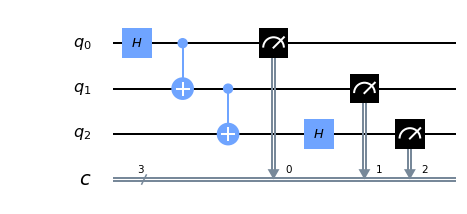

In [0]:
# IBMQ
ibmq_circuit_qasm, ibmq_circuit_statevector = circuit.generate_qiskit_circuit()
print(color.BOLD + "[ Qiskit ]" + color.ENDC)
print(execute(ibmq_circuit_statevector, statevector_simulator).result().data()['statevector'])
ibmq_circuit_qasm.draw(output='mpl')

In [0]:
circuit = cirq.Circuit()
q = cirq.LineQubit.range(3)
q1 = q[0]
q2 = q[1]
q3 = q[2]

circuit.append(cirq.H(q1))
circuit.append(cirq.CX(q1, q2))
circuit.append(cirq.CX(q2, q3))
circuit.append(cirq.H(q3))

cirq.Simulator().simulate(circuit).final_state

array([ 0.49999997+0.j,  0.49999997+0.j,  0.        +0.j, -0.        +0.j,
        0.        +0.j, -0.        +0.j,  0.49999997+0.j, -0.49999997+0.j],
      dtype=complex64)

## Quantum Approximate Optimization Algorithm with quantum simulator
    
    We learned so far what is
    Quantum Approximate Optimization Algorithm is
    Now we are going to check it by code

#### qaoa code

In [0]:
class Qaoa():
    """Quantum Approximate Optimization Algorithm
    This class is built for Maxcut approximation
    """
    def __init__(self,
                 qubit_size: int,
                 edges: list,
                 p: int,
                 gammas=None,
                 betas=None,
                 epsilon=None,
                 lr=None):
        """Generate the circuit for
        quantum approximate optimization algorithm

        Args:
            qubit_size: the size of qubit and also vertices
            edges: express the qubit connection [(0, 1), (0, 3)]
            p: total repeat process
            gammas: used for cost gate
            betas: used for mixer gate
            epsilon: used for calculating gradient
            lr: learning rate for gradient descent
        """
        # Graph information
        self.qubit_size = qubit_size
        self.edges = edges

        # p
        self.p = p

        # gamma and beta
        self.gammas = np.array(gammas)
        self.betas = np.array(betas)

        if self.gammas == None:
            gammas = []
            for _ in range(p):
                gamma = 0.5*math.pi*random.random()
                gammas.append(gamma)
            self.gammas = np.array(gammas)
        elif len(gammas) != p:
            raise ValueError("gammas length->{0} should match p->{1}".format(len(gammas), p))
        if self.betas == None:
            betas = []
            for _ in range(p):
                beta = 0.25*math.pi*random.random()
                betas.append(beta)
            self.betas = np.array(betas)
        elif len(betas) != p:
            raise ValueError("beta length->{0} should match p->{1}".format(len(betas), p))

        # Training hyperparameter
        # epsilon and learning rate
        self.epsilon = epsilon
        self.lr = lr

        if self.epsilon == None:
            self.epsilon = 1e-4
        if self.lr == None:
            self.lr = 1e-2

        # Cost information
        self.generate_cost_information()

        # Create Quantum Simulator
        self.circuit = QuantumSimulator(self.qubit_size)

    def cost_gate(self, gamma, q1, q2):
        self.circuit.cu1(2*gamma, q1, q2)
        self.circuit.u1(-gamma, q1)
        self.circuit.u1(-gamma, q2)
    
    def mixer_gate(self, beta, q):
        self.circuit.rx(2*beta, q)

    def generate_circuit(self):
        # Clear the circuit
        self.circuit.clear_circuit()
        
        # Add hadamard gate
        for i in range(qubit_size):
            self.circuit.h(i)

        # Add cost & mixer gate for p times
        for p_i in range(self.p):
            # Add cost gate for each edge
            for edge in self.edges:
                q1, q2 = edge[0], edge[1]
                self.cost_gate(self.gammas[p_i], q1, q2)

            # Add mixer gate for each vertice
            for i in range(qubit_size):
                self.mixer_gate(self.betas[p_i], i)

    def generate_cost_information(self):
        """Generate total cost for every possible output

        1. Transform to pauli Z basis
        based on pauli-Z basis [0, 1] -> [1, -1]
        Ex: qubit size 2
                        possible output
                      <00> <01> <10> <11>
        qubit size   [[1    1   -1   -1]
                      [1    -1   1   -1]]

        2. Calculate cost based on Hamiltonian
        Ex: edge (0, 1)
        [[1    1   -1   -1]
         [1    -1   1   -1]]
         
        <00> <01> <10> <11>
        [[1   -1   -1   1]]
        """
        # 1. Transform to pauli z basis
        z = np.array([(-1)**(np.arange(2**self.qubit_size) >> i) for i in range(qubit_size-1,-1,-1)])

        # 2. Calculate cost based on Hamiltonian
        self.cost_info = np.zeros((2**self.qubit_size))
        for edge in self.edges:
            e1, e2 = edge[0], edge[1]
            self.cost_info += z[e1] * z[e2]

    def cost(self):
        # Generate circuit
        self.generate_circuit()

        # get amplitude tensor
        self.circuit.execute()
        
        # Calculate probability
        amp = self.circuit.amplitude.reshape(-1)
        prob = amp*amp.conjugate()

        return (np.sum(self.cost_info * prob) / self.qubit_size).real

    def gradient_descent(self):
        # update gammas
        self.gammas += self.epsilon
        grad_gamma = self.cost()
        self.gammas -= 2*self.epsilon
        grad_gamma -= self.cost()
        self.gammas += self.epsilon
        grad_gamma /= 2*self.epsilon

        self.gammas -= self.lr * grad_gamma

        # update betas
        self.betas += self.epsilon
        grad_beta = self.cost()
        self.betas -= 2*self.epsilon
        grad_beta -= self.cost()
        self.betas += self.epsilon
        grad_beta /= 2*self.epsilon

        self.betas -= self.lr * grad_beta
    
    def train(self, epochs=100, print_every=10):
        for i in range(epochs):
            self.gradient_descent()
            if (i+1) % print_every == 0:
                print("{0} / {1} gamma: {2} beta: {3}".format(i+1, epochs, self.gammas, self.betas))
    
    def result(self, result_n):
        self.generate_circuit()
        self.circuit.execute()
        self.qaoa_result = {k:round(v, 4) for k, v in self.circuit.result_prob.items()}
        self.qaoa_result = sorted(self.qaoa_result.items(), reverse=True, key=lambda item: item[1])[:result_n]
        return self.qaoa_result

    def print_circuit(self):
        # Generate circuit
        self.generate_circuit()

        # print by qiskit format
        _, circuit = self.circuit.generate_qiskit_circuit()
        print(circuit)

#### Visualizer

In [0]:
def graph_visualizer(qubit_size, edges, result=None):
    G = nx.Graph()
    V = np.arange(0, qubit_size)
    E = edges

    G.add_nodes_from(V)
    G.add_edges_from(E)

    if result:
        colors = ['r' if v == '1' else 'b' for v in result[::-1]]
    else:
        colors = ['b' for _ in range(qubit_size)]
    default_axes = plt.axes(frameon=True)
    pos = nx.spring_layout(G)
    nx.draw_networkx(G, node_color=colors, ax=default_axes, node_size=600, alpha=1, pos=pos)

In [0]:
def qaoa_result(qubit_size, edges, result):
    graph_visualizer(qubit_size, edges, result[0][0])
    for statevector, probability in result:
        print(statevector, probability)

#### 3 Nodes

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


10 / 100 gamma: [0.64509921] beta: [0.29160289]
20 / 100 gamma: [0.64472888] beta: [0.29248633]
30 / 100 gamma: [0.64435436] beta: [0.2933047]
40 / 100 gamma: [0.64397655] beta: [0.29406324]
50 / 100 gamma: [0.64359625] beta: [0.29476674]
60 / 100 gamma: [0.64321421] beta: [0.29541959]
70 / 100 gamma: [0.6428311] beta: [0.29602585]
80 / 100 gamma: [0.64244754] beta: [0.29658922]
90 / 100 gamma: [0.64206409] beta: [0.29711311]
100 / 100 gamma: [0.64168124] beta: [0.29760066]


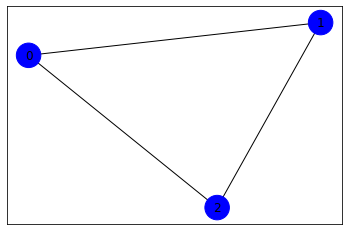

In [0]:
qubit_size = 3
edges = [(0, 1), (1, 2), (0, 2)]
p = 1

# Default value is already supported
# But we could add our own custom value
gammas=None
betas=None
epsilon=None
lr=0.001

t = Qaoa(qubit_size=qubit_size,
         edges=edges,
         p=p,
         gammas=gammas,
         betas=betas,
         epsilon=epsilon,
         lr=lr)

graph_visualizer(qubit_size, edges)
t.train(epochs=100, print_every=10)
result = t.result(10)

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


001 0.1666
010 0.1666
011 0.1666
100 0.1666
101 0.1666
110 0.1666
000 0.0003
111 0.0003


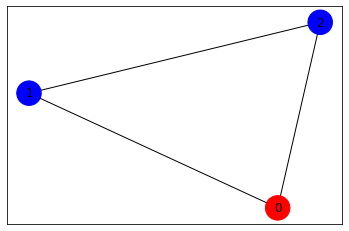

In [0]:
qaoa_result(qubit_size, edges, result)

#### 4 Nodes

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


10 / 100 gamma: [0.01234092] beta: [0.57355119]
20 / 100 gamma: [0.01796261] beta: [0.57324497]
30 / 100 gamma: [0.02358912] beta: [0.57282788]
40 / 100 gamma: [0.02922191] beta: [0.57230049]
50 / 100 gamma: [0.03486238] beta: [0.57166353]
60 / 100 gamma: [0.04051192] beta: [0.57091788]
70 / 100 gamma: [0.04617183] beta: [0.57006457]
80 / 100 gamma: [0.05184339] beta: [0.56910481]
90 / 100 gamma: [0.05752777] beta: [0.56803994]
100 / 100 gamma: [0.06322611] beta: [0.56687149]


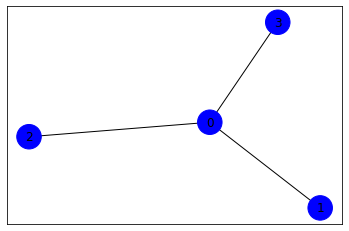

In [0]:
qubit_size = 4
edges = [(0, 1), (0, 2), (0, 3)]
p = 1

# Default value is already supported
# But we could add our own custom value
gammas=None
betas=None
epsilon=None
lr=0.001

t = Qaoa(qubit_size=qubit_size,
         edges=edges,
         p=p,
         gammas=gammas,
         betas=betas,
         epsilon=epsilon,
         lr=lr)

graph_visualizer(qubit_size, edges)
t.train(epochs=100, print_every=10)
result = t.result(10)

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


0001 0.0722
1110 0.0722
0011 0.0653
0101 0.0653
0110 0.0653
1001 0.0653
1010 0.0653
1100 0.0653
0010 0.0593
0100 0.0593


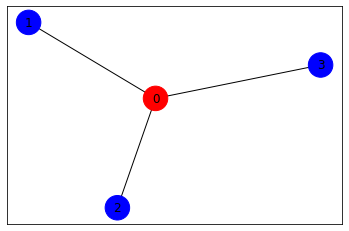

In [0]:
qaoa_result(qubit_size, edges, result)

#### 6 Nodes

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


10 / 100 gamma: [0.76825858 1.45719608 1.20164301 0.02072876 1.23939744] beta: [0.62466343 0.17538202 0.27801607 0.33349176 0.12194649]
20 / 100 gamma: [ 0.73986586  1.42880335  1.17325029 -0.00766396  1.21100471] beta: [0.61949032 0.17020891 0.27284295 0.32831865 0.11677338]
30 / 100 gamma: [ 0.72623979  1.41517729  1.15962422 -0.02129003  1.19737865] beta: [0.61541656 0.16613515 0.2687692  0.32424489 0.11269962]
40 / 100 gamma: [ 0.71907248  1.40800997  1.15245691 -0.02845734  1.19021133] beta: [0.61242019 0.16313878 0.26577283 0.32124852 0.10970326]
50 / 100 gamma: [ 0.71503725  1.40397474  1.14842168 -0.03249257  1.1861761 ] beta: [0.61034641 0.161065   0.26369905 0.31917475 0.10762948]
60 / 100 gamma: [ 0.71266306  1.40160056  1.14604749 -0.03486676  1.18380192] beta: [0.60895731 0.1596759  0.26230995 0.31778564 0.10624037]
70 / 100 gamma: [ 0.71122584  1.40016334  1.14461027 -0.03630398  1.1823647 ] beta: [0.60804352 0.15876211 0.26139616 0.31687185 0.10532658]
80 / 100 gamma: [ 

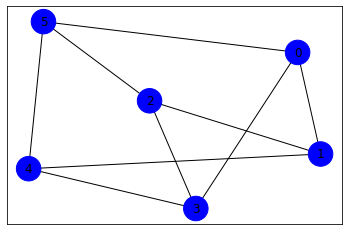

In [0]:
qubit_size = 6
edges = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (0, 5), (1, 4), (2, 5), (0, 3)]
p = 5

# Default value is already supported
# But we could add our own custom value
gammas=None
betas=None
epsilon=None
lr=0.001

t = Qaoa(qubit_size=qubit_size,
         edges=edges,
         p=p,
         gammas=gammas,
         betas=betas,
         epsilon=epsilon,
         lr=lr)

graph_visualizer(qubit_size, edges)
t.train(epochs=100, print_every=10)
result = t.result(10)

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


010101 0.2798
101010 0.2798
000000 0.0167
111111 0.0167
000101 0.0108
001010 0.0108
010001 0.0108
010100 0.0108
010111 0.0108
011101 0.0108


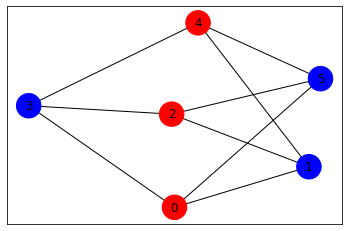

In [0]:
qaoa_result(qubit_size, edges, result)

In [0]:
result = t.result(16)
for statevector, probability in result:
    print(statevector, probability)

010101 0.2642
101010 0.2642
000101 0.0204
001010 0.0204
010001 0.0204
010100 0.0204
010111 0.0204
011101 0.0204
100010 0.0204
101000 0.0204
101011 0.0204
101110 0.0204
110101 0.0204
111010 0.0204
000000 0.0178
111111 0.0178


#### 10 nodes

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


10 / 100 gamma: [1.08349478] beta: [0.61366957]
20 / 100 gamma: [1.08088307] beta: [0.60093305]
30 / 100 gamma: [1.07814878] beta: [0.58872845]
40 / 100 gamma: [1.07530858] beta: [0.57706212]
50 / 100 gamma: [1.07237826] beta: [0.56593559]
60 / 100 gamma: [1.06937259] beta: [0.55534609]
70 / 100 gamma: [1.06630532] beta: [0.54528715]
80 / 100 gamma: [1.06318904] beta: [0.53574914]
90 / 100 gamma: [1.06003522] beta: [0.5267198]
100 / 100 gamma: [1.05685423] beta: [0.51818473]


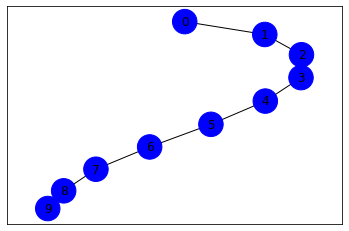

In [0]:
qubit_size = 10
edges = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9)]
p = 1

# Default value is already supported
# But we could add our own custom value
gammas=None
betas=None
epsilon=None
lr=0.001

t = Qaoa(qubit_size=qubit_size,
         edges=edges,
         p=p,
         gammas=gammas,
         betas=betas,
         epsilon=epsilon,
         lr=lr)

graph_visualizer(qubit_size, edges)
t.train(epochs=100, print_every=10)
result = t.result(10)

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


0101010101 0.0302
1010101010 0.0302
0100101010 0.0131
0101010010 0.0131
1010101101 0.0131
1011010101 0.0131
0101010110 0.012
0110101010 0.012
1001010101 0.012
1010101001 0.012


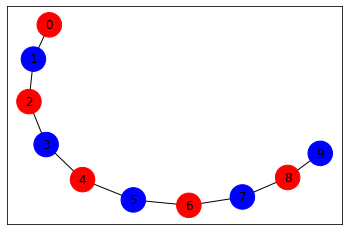

In [0]:
qaoa_result(qubit_size, edges, result)